# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                            
Sample_163  B7Z4G8;F5GZ08;P51693                         21.301
Sample_026  Q06828                                       18.708
Sample_099  A0A0A0MTH0;Q8N0W4;Q8N0W4-2;Q8NFZ3;Q8NFZ3-2   16.444
Sample_056  P14621;U3KPX8;U3KQL2                         16.674
Sample_179  A0A075B6I1                                   17.986
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                 
Sample_136  A0A0C4DGV4;E9PLX3;O43504;R4GMU8   13.586
Sample_112  P36269;P36269-2;P36269-3           7.445
Sample_100  Q5R3F8                            12.122
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.764
            A0A075B6Q5                 13.212
            A0A075B6R2                 12.838
            A0A075B6S5                 11.084
            A0A087WSY4                 13.285
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.309
            Q9UI40;Q9UI40-2            12.271
            Q9UIW2                     13.741
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.788
            Q9UP79                     12.576
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.268,15.050,16.842,19.863,13.572,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.334,19.067,...,15.528,15.576,11.309,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.154,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.501,17.705,17.039,14.661,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.168,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.902,15.345,17.084,18.708,14.249,19.433,9.848,8.332
Sample_207,15.739,16.877,15.469,16.898,13.382,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.764,...,16.012,15.178,13.691,15.050,16.842,19.863,14.132,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.232,19.067,16.188,...,15.528,15.576,12.956,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.675,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.000,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.291,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.125,15.345,17.084,18.708,14.249,19.433,11.855,11.414
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 367.41it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.38it/s]

100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.37it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

100%|██████████| 4/4 [00:00<00:00,  3.76it/s]

100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.21it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.37it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.86it/s]

100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.00it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.45it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.85it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.46it/s]

100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.65it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.46it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.95it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.69it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.42it/s]

100%|██████████| 7/7 [00:01<00:00,  3.37it/s]

100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.39it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.18it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.68it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.31it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.22it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.29it/s]

100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

100%|██████████| 8/8 [00:02<00:00,  3.50it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.74it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.99it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.34it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.86it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.57it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.69it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.45it/s]

100%|██████████| 9/9 [00:02<00:00,  3.25it/s]

100%|██████████| 9/9 [00:02<00:00,  3.72it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.42it/s]

 30%|███       | 3/10 [00:00<00:01,  5.05it/s]

 40%|████      | 4/10 [00:00<00:01,  4.08it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.89it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.12it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.65it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.45it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.35it/s]

100%|██████████| 10/10 [00:03<00:00,  2.18it/s]

100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.93it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.37it/s]

 36%|███▋      | 4/11 [00:01<00:03,  1.88it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.83it/s]

 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.05it/s]

 82%|████████▏ | 9/11 [00:04<00:00,  2.33it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.58it/s]

100%|██████████| 11/11 [00:04<00:00,  2.78it/s]

100%|██████████| 11/11 [00:04<00:00,  2.28it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.01it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.34it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.96it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.74it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.57it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.42it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.27it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.16it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.77it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.12it/s]

100%|██████████| 12/12 [00:04<00:00,  1.96it/s]

100%|██████████| 12/12 [00:04<00:00,  2.77it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.67it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.36it/s]

 31%|███       | 4/13 [00:01<00:04,  2.03it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.07it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.10it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.22it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.36it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.44it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.53it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.60it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.79it/s]

100%|██████████| 13/13 [00:05<00:00,  2.93it/s]

100%|██████████| 13/13 [00:05<00:00,  2.51it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.24it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.90it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.40it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.28it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.31it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.32it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.27it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.20it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.23it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.86it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.56it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.37it/s]

100%|██████████| 14/14 [00:04<00:00,  2.20it/s]

100%|██████████| 14/14 [00:04<00:00,  2.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.16it/s]

 20%|██        | 3/15 [00:00<00:02,  4.52it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.31it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.60it/s]

 40%|████      | 6/15 [00:02<00:03,  2.35it/s]

 47%|████▋     | 7/15 [00:02<00:04,  2.00it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.92it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.92it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.89it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.04it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.11it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.15it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.27it/s]

100%|██████████| 15/15 [00:06<00:00,  2.34it/s]

100%|██████████| 15/15 [00:06<00:00,  2.32it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.045 0.004          0.706 0.393       0.109   
2             0.004 0.000      0.049 0.004          0.661 0.100       0.563   
3             0.004 0.000      0.047 0.001          0.747 0.093       0.697   
4             0.004 0.000      0.048 0.004          0.728 0.093       0.713   
5             0.004 0.000      0.047 0.004          0.783 0.086       0.747   
6             0.004 0.000      0.047 0.002          0.784 0.097       0.748   
7             0.004 0.000      0.047 0.001          0.790 0.102       0.747   
8             0.004 0.000      0.045 0.006          0.801 0.080       0.820   
9             0.004 0.000      0.048 0.001          0.806 0.081       0.805   
10            0.006 0.004      0.061 0.025          0.803 0.083       0.805   
11            0.005 0.004      0.062 0.034          0.796 0.083       0.804   
12            0.005 0.003      0.065 0.031          0.791 0.081       0.803   
13            0.007 0.006      0.075 0.033          0.789 0.089       0.803   
14            0.008 0.007      0.069 0.029          0.790 0.090       0.803   
15            0.005 0.003      0.053 0.014          0.787 0.089       0.796   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.181 0.134                  0.547 0.042        0.855   
2          0.106   0.601 0.082                  0.673 0.060        0.730   
3          0.107   0.715 0.080                  0.759 0.065        0.843   
4          0.109   0.715 0.084                  0.757 0.069        0.841   
5          0.129   0.756 0.085                  0.795 0.067        0.846   
6          0.107   0.760 0.082                  0.796 0.068        0.864   
7          0.110   0.762 0.085                  0.799 0.070        0.872   
8          0.098   0.806 0.069                  0.834 0.059        0.903   
9          0.103   0.801 0.071                  0.830 0.060        0.900   
10         0.103   0.800 0.072                  0.829 0.061        0.900   
11         0.105   0.796 0.073                  0.825 0.062        0.899   
12         0.106   0.793 0.075                  0.823 0.064        0.899   
13         0.100   0.791 0.075                  0.821 0.063        0.904   
14         0.104   0.791 0.075                  0.821 0.064        0.901   
15         0.099   0.787 0.073                  0.817 0.062        0.900   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.829 0.087        210.000 0.000  
2          0.073                  0.663 0.089        210.000 0.000  
3          0.070                  0.810 0.092        210.000 0.000  
4          0.069                  0.809 0.088        210.000 0.000  
5          0.066                  0.810 0.085        210.000 0.000  
6          0.064                  0.853 0.072        210.000 0.000  
7          0.062                  0.862 0.069        210.000 0.000  
8          0.050                  0.892 0.050        210.000 0.000  
9          0.051                  0.887 0.053        210.000 0.000  
10         0.051                  0.887 0.053        210.000 0.000  
11         0.051                  0.886 0.054        210.000 0.000  
12         0.051                  0.885 0.054        210.000 0.000  
13         0.051                  0.895 0.051        210.000 0.000  
14         0.051                  0.892 0.052        210.000 0.000  
15         0.050                  0.891 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 427.95it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.23it/s]

100%|██████████| 3/3 [00:00<00:00,  3.79it/s]

100%|██████████| 3/3 [00:00<00:00,  3.99it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.78it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.97it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.07it/s]

 80%|████████  | 4/5 [00:02<00:00,  1.84it/s]

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.32it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.25it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.81it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.65it/s]

100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.83it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.46it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.42it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.16it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.03it/s]

100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.36it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.53it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.01it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.78it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.73it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.67it/s]

100%|██████████| 8/8 [00:02<00:00,  2.73it/s]

100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.22it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.47it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.83it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.72it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.55it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.66it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.67it/s]

100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.32it/s]

 30%|███       | 3/10 [00:01<00:03,  2.32it/s]

 40%|████      | 4/10 [00:01<00:03,  1.93it/s]

 50%|█████     | 5/10 [00:02<00:03,  1.66it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.83it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.06it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.23it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.40it/s]

100%|██████████| 10/10 [00:04<00:00,  2.57it/s]

100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.04it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.94it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.36it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.90it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.39it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.07it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.83it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.70it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.60it/s]

100%|██████████| 11/11 [00:05<00:00,  1.76it/s]

100%|██████████| 11/11 [00:05<00:00,  2.11it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.81it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.59it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.58it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.50it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.53it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.63it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.68it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.63it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.71it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.84it/s]

100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.43it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.05it/s]

 31%|███       | 4/13 [00:01<00:02,  3.57it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.47it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.24it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.13it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.03it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.15it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.92it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.79it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.72it/s]

100%|██████████| 13/13 [00:06<00:00,  1.74it/s]

100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.67it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.96it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.14it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.98it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.03it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.99it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.07it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.15it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.28it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.28it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.33it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.46it/s]

100%|██████████| 14/14 [00:05<00:00,  2.57it/s]

100%|██████████| 14/14 [00:05<00:00,  2.35it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.04it/s]

 20%|██        | 3/15 [00:00<00:03,  3.53it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.01it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.70it/s]

 40%|████      | 6/15 [00:02<00:03,  2.62it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.68it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.62it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.37it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.07it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.95it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.85it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.07it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.18it/s]

100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

100%|██████████| 15/15 [00:06<00:00,  2.38it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.067 0.029          0.907 0.145       0.178   
2             0.007 0.007      0.077 0.030          0.600 0.108       0.491   
3             0.005 0.004      0.070 0.027          0.812 0.079       0.724   
4             0.004 0.003      0.056 0.019          0.806 0.083       0.765   
5             0.005 0.005      0.059 0.020          0.798 0.084       0.759   
6             0.005 0.005      0.066 0.032          0.798 0.090       0.757   
7             0.006 0.006      0.072 0.030          0.835 0.086       0.792   
8             0.005 0.004      0.065 0.023          0.828 0.093       0.789   
9             0.006 0.005      0.070 0.026          0.819 0.081       0.844   
10            0.006 0.006      0.082 0.043          0.817 0.076       0.823   
11            0.005 0.002      0.054 0.015          0.814 0.076       0.813   
12            0.006 0.004      0.080 0.029          0.805 0.076       0.803   
13            0.006 0.004      0.053 0.013          0.803 0.073       0.802   
14            0.006 0.005      0.072 0.026          0.817 0.081       0.806   
15            0.006 0.005      0.070 0.029          0.816 0.088       0.796   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.093   0.286 0.124                  0.580 0.043        0.854   
2          0.128   0.531 0.100                  0.624 0.067        0.713   
3          0.107   0.760 0.072                  0.799 0.057        0.905   
4          0.110   0.779 0.073                  0.813 0.060        0.906   
5          0.108   0.773 0.076                  0.808 0.062        0.902   
6          0.112   0.772 0.082                  0.807 0.067        0.900   
7          0.105   0.808 0.073                  0.837 0.062        0.908   
8          0.109   0.803 0.078                  0.832 0.066        0.907   
9          0.098   0.828 0.071                  0.853 0.062        0.916   
10         0.093   0.817 0.066                  0.843 0.057        0.916   
11         0.098   0.810 0.070                  0.838 0.059        0.915   
12         0.097   0.800 0.067                  0.829 0.057        0.913   
13         0.097   0.798 0.066                  0.828 0.056        0.913   
14         0.106   0.806 0.067                  0.835 0.056        0.918   
15         0.105   0.801 0.076                  0.831 0.063        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.088        210.000 0.000  
2          0.079                  0.659 0.097        210.000 0.000  
3          0.047                  0.883 0.058        210.000 0.000  
4          0.046                  0.883 0.056        210.000 0.000  
5          0.049                  0.881 0.058        210.000 0.000  
6          0.051                  0.879 0.059        210.000 0.000  
7          0.054                  0.890 0.062        210.000 0.000  
8          0.053                  0.890 0.061        210.000 0.000  
9          0.048                  0.903 0.052        210.000 0.000  
10         0.045                  0.900 0.049        210.000 0.000  
11         0.044                  0.898 0.049        210.000 0.000  
12         0.043                  0.896 0.047        210.000 0.000  
13         0.043                  0.896 0.047        210.000 0.000  
14         0.042                  0.903 0.046        210.000 0.000  
15         0.044                  0.901 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 911.81it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.69it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.02it/s]

100%|██████████| 3/3 [00:00<00:00, 19.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 19.13it/s]

100%|██████████| 4/4 [00:00<00:00, 13.97it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.38it/s]

100%|██████████| 5/5 [00:00<00:00, 14.49it/s]

100%|██████████| 5/5 [00:00<00:00, 14.04it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.46it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 11.48it/s]

100%|██████████| 6/6 [00:00<00:00, 11.98it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.79it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.41it/s]

100%|██████████| 7/7 [00:00<00:00, 12.19it/s]

100%|██████████| 7/7 [00:00<00:00, 12.78it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 15.52it/s]

 50%|█████     | 4/8 [00:00<00:00, 12.63it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.92it/s]

100%|██████████| 8/8 [00:00<00:00, 12.26it/s]

100%|██████████| 8/8 [00:00<00:00, 12.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.25it/s]

 44%|████▍     | 4/9 [00:00<00:00, 10.80it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 10.90it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  9.72it/s]

100%|██████████| 9/9 [00:00<00:00, 10.59it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.88it/s]

 40%|████      | 4/10 [00:00<00:00, 10.88it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.16it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.19it/s]

100%|██████████| 10/10 [00:00<00:00, 10.27it/s]

100%|██████████| 10/10 [00:00<00:00, 10.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.91it/s]

 36%|███▋      | 4/11 [00:00<00:00, 13.50it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 12.01it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.00it/s]

 91%|█████████ | 10/11 [00:00<00:00,  9.73it/s]

100%|██████████| 11/11 [00:01<00:00, 10.42it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 15.90it/s]

 42%|████▏     | 5/12 [00:00<00:00, 11.59it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 10.62it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  9.67it/s]

 83%|████████▎ | 10/12 [00:00<00:00,  9.42it/s]

100%|██████████| 12/12 [00:01<00:00,  8.98it/s]

100%|██████████| 12/12 [00:01<00:00,  9.80it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 16.03it/s]

 31%|███       | 4/13 [00:00<00:00, 12.37it/s]

 46%|████▌     | 6/13 [00:00<00:00, 11.73it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 12.01it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 10.35it/s]

 92%|█████████▏| 12/13 [00:01<00:00, 11.32it/s]

100%|██████████| 13/13 [00:01<00:00, 11.22it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 19.89it/s]

 29%|██▊       | 4/14 [00:00<00:00, 12.94it/s]

 43%|████▎     | 6/14 [00:00<00:00, 10.73it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 10.44it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 10.63it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.87it/s]

100%|██████████| 14/14 [00:01<00:00, 11.47it/s]

100%|██████████| 14/14 [00:01<00:00, 11.36it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 15.20it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.52it/s]

 47%|████▋     | 7/15 [00:00<00:00, 11.05it/s]

 60%|██████    | 9/15 [00:00<00:00, 11.57it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 10.21it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.73it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.36it/s]

100%|██████████| 15/15 [00:01<00:00, 10.63it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.068 0.022          0.370 0.413       0.037   
2             0.006 0.005      0.073 0.028          0.599 0.086       0.481   
3             0.007 0.006      0.077 0.032          0.611 0.098       0.488   
4             0.006 0.005      0.069 0.030          0.647 0.104       0.562   
5             0.007 0.004      0.070 0.030          0.623 0.099       0.545   
6             0.007 0.006      0.068 0.028          0.626 0.104       0.537   
7             0.006 0.005      0.067 0.029          0.639 0.110       0.533   
8             0.006 0.005      0.062 0.025          0.627 0.104       0.529   
9             0.007 0.006      0.065 0.027          0.628 0.096       0.531   
10            0.004 0.002      0.063 0.020          0.628 0.088       0.559   
11            0.004 0.002      0.056 0.017          0.617 0.098       0.542   
12            0.006 0.004      0.065 0.025          0.611 0.095       0.544   
13            0.007 0.006      0.071 0.031          0.600 0.094       0.536   
14            0.008 0.007      0.074 0.031          0.595 0.098       0.538   
15            0.005 0.002      0.057 0.022          0.595 0.104       0.526   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.044   0.065 0.075                  0.508 0.022        0.730   
2          0.133   0.524 0.106                  0.623 0.064        0.711   
3          0.131   0.532 0.106                  0.629 0.065        0.707   
4          0.122   0.595 0.098                  0.668 0.071        0.729   
5          0.130   0.574 0.101                  0.651 0.070        0.723   
6          0.138   0.571 0.112                  0.652 0.078        0.723   
7          0.135   0.573 0.107                  0.654 0.079        0.734   
8          0.125   0.566 0.099                  0.647 0.073        0.727   
9          0.122   0.568 0.095                  0.648 0.069        0.723   
10         0.129   0.585 0.099                  0.659 0.069        0.726   
11         0.119   0.571 0.096                  0.647 0.068        0.736   
12         0.106   0.570 0.089                  0.644 0.067        0.735   
13         0.111   0.561 0.093                  0.637 0.067        0.729   
14         0.112   0.559 0.093                  0.634 0.069        0.727   
15         0.128   0.551 0.102                  0.630 0.074        0.728   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.657 0.095        210.000 0.000  
2          0.071                  0.635 0.086        210.000 0.000  
3          0.071                  0.633 0.084        210.000 0.000  
4          0.076                  0.674 0.083        210.000 0.000  
5          0.078                  0.663 0.085        210.000 0.000  
6          0.076                  0.667 0.083        210.000 0.000  
7          0.077                  0.677 0.088        210.000 0.000  
8          0.076                  0.674 0.084        210.000 0.000  
9          0.072                  0.662 0.086        210.000 0.000  
10         0.077                  0.666 0.095        210.000 0.000  
11         0.075                  0.670 0.091        210.000 0.000  
12         0.077                  0.665 0.093        210.000 0.000  
13         0.075                  0.661 0.091        210.000 0.000  
14         0.075                  0.661 0.091        210.000 0.000  
15         0.079                  0.659 0.093 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,2,14
score_time,13,10,3
test_precision,9,1,4
test_recall,8,9,4
test_f1,8,9,4
test_balanced_accuracy,8,9,4
test_roc_auc,13,14,11
test_average_precision,13,9,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.10it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.47it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.22it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.06it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.96it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.60it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.57it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.60it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.53it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.36it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.50it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.55it/s]

100%|██████████| 14/14 [00:05<00:00,  2.65it/s]

100%|██████████| 14/14 [00:05<00:00,  2.73it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.90it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.57it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.53it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.93it/s]

100%|██████████| 11/11 [00:00<00:00, 10.80it/s]

100%|██████████| 11/11 [00:00<00:00, 11.44it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.73it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.47it/s]

 31%|███       | 4/13 [00:00<00:02,  3.98it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.66it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.58it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.49it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.99it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.97it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.83it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.74it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.84it/s]

100%|██████████| 13/13 [00:04<00:00,  2.87it/s]

100%|██████████| 13/13 [00:04<00:00,  3.20it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


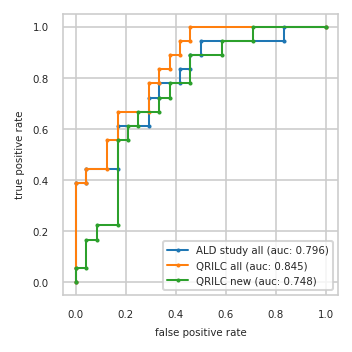

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.389     0.000 0.389     0.042 0.056
3          0.042 0.389     0.042 0.389     0.042 0.167
4          0.042 0.444     0.042 0.444     0.083 0.167
5          0.167 0.444     0.125 0.444     0.083 0.222
6          0.167 0.611     0.125 0.556     0.167 0.222
7          0.292 0.611     0.167 0.556     0.167 0.556
8          0.292 0.722     0.167 0.667     0.208 0.556
9          0.333 0.722     0.292 0.667     0.208 0.611
10         0.333 0.778     0.292 0.778     0.250 0.611
11         0.417 0.778     0.333 0.778     0.250 0.667
12         0.417 0.833     0.333 0.833     0.333 0.667
13         0.458 0.833     0.375 0.833     0.333 0.722
14         0.458 0.889     0.375 0.889     0.375 0.722
15         0.500 0.889     0.417 0.889     0.375 0.778
16         0.500 0.944     0.417 0.944     0.458 0.778
17         0.833 0.944     0.458 0.944     0.458 0.889
18         0.833 1.000     0.458 1.000     0.583 0.889
19         1.000 1.000     1.000 1.000     0.583 0.944
20           NaN   NaN       NaN   NaN     0.708 0.944
21           NaN   NaN       NaN   NaN     0.708 1.000
22           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,P10644;P10644-2
1,Q14165,P60709;P63261,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2
2,P08670,A0A0C4DH07;Q8N2S1;Q8N2S1-2;Q8N2S1-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
3,B0QYF8;P02144,P10636-2;P10636-6,Q14894
4,P04075,A0A0A0MRJ7;P12259,B8ZZL8;P61604
5,P61981,P61981,D6R956;P09936
6,P01597;P04432,P14174,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
7,P14174,P04075,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2
8,A0A0C4DGY8;D6RA00;Q9UHY7,P00338;P00338-3,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


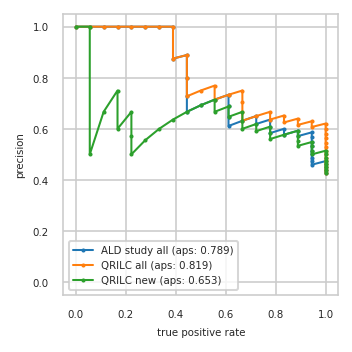

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.621 1.000     0.552 0.889
14         0.571 0.889     0.607 0.944     0.571 0.889
15         0.593 0.889     0.630 0.944     0.593 0.889
16         0.577 0.833     0.615 0.889     0.577 0.833
17         0.600 0.833     0.640 0.889     0.560 0.778
18         0.583 0.778     0.625 0.833     0.583 0.778
19         0.609 0.778     0.652 0.833     0.609 0.778
20         0.636 0.778     0.636 0.778     0.591 0.722
21         0.619 0.722     0.667 0.778     0.619 0.722
22         0.650 0.722     0.650 0.722     0.600 0.667
23         0.632 0.667     0.632 0.667     0.632 0.667
24         0.611 0.611     0.667 0.667     0.667 0.667
25         0.647 0.611     0.706 0.667     0.647 0.611
26         0.688 0.611     0.750 0.667     0.688 0.611
27         0.733 0.611     0.733 0.611     0.667 0.556
28         0.714 0.556     0.714 0.556     0.714 0.556
29         0.692 0.500     0.769 0.556     0.692 0.500
30         0.667 0.444     0.750 0.500     0.667 0.444
31         0.727 0.444     0.727 0.444     0.636 0.389
32         0.800 0.444     0.800 0.444     0.600 0.333
33         0.889 0.444     0.889 0.444     0.556 0.278
34         0.875 0.389     0.875 0.389     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


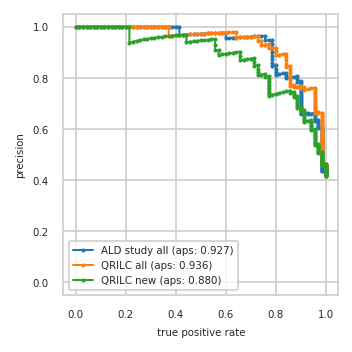

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


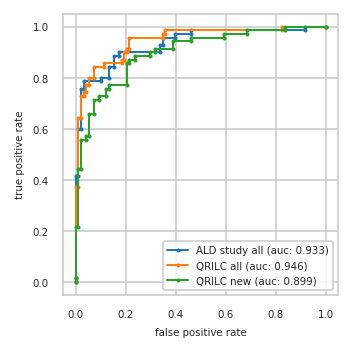

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}